In [3]:
%matplotlib inline
import yahoofinancials as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import datetime
import random

# Para fazer o backtesting
from backtesting_v2 import evaluateHist, evaluateIntr, Strategy, Order

In [176]:
tickers = ['AAPL', 'ITUB4.SA', 'MRFG3.SA']


start_date = '2018-03-06'
end_date   = '2023-03-06'

for ticker in tickers:
    data = yf.YahooFinancials(ticker).get_historical_price_data(start_date, end_date, 'daily')
    # Ler os dados do JSON
    raw = pd.DataFrame(data[ticker]['prices']).dropna()
    # Converter a data para o tipo correto datetime
    raw['formatted_date'] = pd.to_datetime(raw['formatted_date'])
    # Indica a data como o índice de cada linha
    raw = raw.set_index('formatted_date')
    # Removendo as colunas que não interessam
    df = raw.iloc[:,1:]

    # Acertando a ordem das colunas
    df = df.reindex(columns=['open', 'high', 'low', 'close', 'adjclose', 'volume'])
    # Salvando o CSV
    df.to_csv(f'{ticker}.csv')

In [177]:
df_aapl = pd.read_csv('AAPL.csv')
df_aapl.head()

,formatted_date,open,high,low,close,adjclose,volume
0,2018-03-06,44.477501,44.562500,44.032501,44.167500,42.105812,95154000
1,2018-03-07,43.735001,43.962502,43.567501,43.757500,41.714947,126814000
2,2018-03-08,43.869999,44.279999,43.767502,44.235001,42.170155,95096400
3,2018-03-09,44.490002,45.000000,44.347500,44.994999,42.894680,128740800
4,2018-03-12,45.072498,45.597500,45.052502,45.430000,43.309376,128828400


### Introdução:
Este código em Python implementa uma estratégia de negociação para investimentos em bolsa de valores, usando três indicadores: MACD, Oscilador Estocástico e Média Móvel. O objetivo é gerar sinais de compra e venda com base na combinação desses indicadores e, assim, obter lucros no mercado.

### Metodologia:
Os três indicadores utilizados são:

MACD (Moving Average Convergence Divergence): Este indicador é calculado subtraindo a média móvel exponencial (EMA) de período mais rápido da EMA de período mais lento. Em seguida, é plotada uma média móvel exponencial adicional do resultado, chamada de "linha de sinal". Quando a linha MACD cruza acima da linha de sinal, é considerado um sinal de compra, e quando cruza abaixo, é um sinal de venda.
Oscilador Estocástico: Este indicador compara o preço atual de um ativo com seu intervalo de preço durante um período de tempo especificado para determinar a intensidade da pressão de compra ou venda. Quando o oscilador estocástico sobe acima do nível de sobrevenda (geralmente 20), é considerado um sinal de compra, e quando cai abaixo do nível de sobrecompra (geralmente 80), é um sinal de venda.
Média Móvel: Este indicador calcula a média dos preços de fechamento de um ativo em um período de tempo especificado. Quando o preço atual fica acima da média móvel, é um sinal de compra, e quando fica abaixo, é um sinal de venda.
O código mescla os sinais gerados pelos três indicadores usando um mecanismo de votação, onde cada sinal é ponderado igualmente. Se o resultado da votação for positivo, a estratégia entra em uma posição comprada, e se for negativo, entra em uma posição vendida. A posição é atualizada somente quando há uma mudança de sinal.

Para determinar o tamanho da posição em cada operação, foi utilizado um percentual de risco fixo de 10% do capital disponível. Essa estratégia permite controlar o risco de cada operação de forma consistente e proporcional ao capital disponível, sem arriscar uma quantidade excessiva de capital em cada negociação. A função "calculate_position_size" foi configurada para calcular o tamanho da posição com base nesse percentual de risco e no capital disponível, garantindo assim que cada operação tenha um tamanho de posição apropriado.

O código também implementa um stop gain e stop loss, onde a posição é fechada se houver um ganho ou perda máxima definidos pela variável "stop_gain" e "stop_loss".

### Parâmetros utilizados:

Para os indicadores, os seguintes parâmetros foram utilizados:

1. MACD: Slow = 26, Fast = 12, Signal = 9
1. Stochastic Oscillator: K Period = 14, D Period = 3, Overbought = 80, Oversold = 20
1. Moving Average: Period = 20

Esses valores foram selecionados com base em análises técnicas e pesquisas de mercado.
O MACD é um indicador de tendência que combina médias móveis exponenciais (EMA) de diferentes períodos para identificar possíveis pontos de inflexão. O uso de um período mais longo para o MACD lento pode ajudar a identificar tendências de longo prazo, enquanto o período mais curto para o MACD rápido pode ajudar a identificar movimentos de curto prazo. O período do sinal é usado para suavizar as mudanças e fornecer sinais mais precisos.

O oscilador estocástico é um indicador de momentum que compara o preço de fechamento atual com uma faixa de preços mais baixos e mais altos em um determinado período de tempo. Um período K mais longo pode fornecer um sinal mais suave, enquanto um período D mais curto pode ajudar a identificar mudanças de curto prazo. Os níveis de sobrecompra e sobrevenda foram escolhidos com base em análises técnicas.

A média móvel é um indicador de tendência que suaviza o preço ao longo do tempo. Um período mais longo pode ser útil para identificar tendências de longo prazo, enquanto um período mais curto pode ser usado para identificar mudanças de curto prazo.

Para os parâmetros do stop gain/stop loss, foram utilizados:

1. Stop Gain = 10%
1. Stop Loss = -5%

Esses valores foram escolhidos com base em análises de risco e recompensa. O stop gain foi definido em 10% para capturar ganhos razoáveis, enquanto o stop loss foi definido em -5% para limitar as perdas. 

In [194]:
class MACDStochasticMA(Strategy):
    def __init__(self):
        # Parameters for MACD indicator
        self.macd_slow = 26
        self.macd_fast = 12
        self.macd_signal = 9
        # Parameters for Stochastic oscillator
        self.stoch_k_period = 14
        self.stoch_d_period = 3
        self.stoch_overbought = 80
        self.stoch_oversold = 20

        # Parameters for moving average
        self.ma_period = 20
        self.ma_indicator = []

        # Lists to store prices and indicators
        self.prices = []
        self.macd_indicator = []
        self.stoch_indicator_k = []
        self.stoch_indicator_d = []

        # Current position
        self.side = 0

        # Initial capital and available capital
        self.init_capital = 1000
        self.avail_capital = self.init_capital
        self.risk_percent = 0.1
        self.entry_price = None
        self.volume = None

    def calculate_position_size(self, price):
        # Calculate the position size based on risk percent and available capital
        return int((self.risk_percent * self.avail_capital) / price)

    def receive(self, event):
        # Extract current price from event
        price = event.price[3]
        self.prices.append(price)

        # Only start generating signals when we have enough historical data
        if len(self.prices) >= max(self.macd_slow, self.stoch_k_period, self.ma_period) + self.macd_signal + self.stoch_d_period:
            # Calculate MACD indicator
            fast_ema = pd.Series(self.prices).ewm(span=self.macd_fast).mean()
            slow_ema = pd.Series(self.prices).ewm(span=self.macd_slow).mean()
            macd = fast_ema - slow_ema
            signal_ema = macd.ewm(span=self.macd_signal).mean()
            self.macd_indicator.append([macd.iloc[-1], signal_ema.iloc[-1]])

            # Calculate Stochastic oscillator indicator            
            last_k_period = self.prices[-self.stoch_k_period:]
            # highest high and lowest low for the last k periods
            hh = max(last_k_period)
            ll = min(last_k_period)
            k = 100 * (price - ll) / (hh - ll)
            d = pd.Series(self.stoch_indicator_k).ewm(span=self.stoch_d_period).mean().iloc[-1] if self.stoch_indicator_k else k
            self.stoch_indicator_k.append(k)
            self.stoch_indicator_d.append(d)

            # Calculate moving average indicator
            ma = pd.Series(self.prices).rolling(window=self.ma_period).mean().iloc[-1]
            self.ma_indicator.append(ma)
            
            # Determine position based on signals
            macd_signal  = 1 if macd.iloc[-1] > signal_ema.iloc[-1] else -1
            stoch_signal = 1 if k > d and k < self.stoch_overbought else -1 if k < d and k > self.stoch_oversold else 0
            ma_signal    = 1 if price > ma else -1

            # Combine signals using a voting mechanism
            signal = macd_signal + stoch_signal + ma_signal

            # Determine position based on signal
            if signal > 0:
                signal = 1
            elif signal < 0:
                signal = -1

            # Update position
            if signal != 0 and self.side != signal:
                if self.side == 1:
                    self.submit(self.id, Order(event.instrument, Order.S, self.volume, 0))
                elif self.side == -1:
                    self.submit(self.id, Order(event.instrument, Order.B, -self.volume, 0))

                self.volume = self.calculate_position_size(price)
                if self.volume != 0:
                    if signal == 1:
                        self.submit(self.id, Order(event.instrument, Order.B, self.volume, 0))
                    elif signal == -1:
                        self.submit(self.id, Order(event.instrument, Order.SS, -self.volume, 0))

                    self.side = signal
                    self.entry_price = price
                else:
                    self.side = 0
                    self.entry_price = None

            # Check for stop gain or stop loss
            if self.entry_price:
                stop_gain = 0.1
                stop_loss = -0.05
                price_change = (price - self.entry_price) / self.entry_price
                if self.side == 1:
                    if (price_change >= stop_gain) or (price_change < stop_loss):
                        self.submit(self.id, Order(event.instrument, Order.S, self.volume, 0))
                        self.side = 0

                if self.side == -1:
                    if (price_change <= -stop_gain) or (price_change > -stop_loss):
                        self.submit(self.id, Order(event.instrument, Order.B, -self.volume, 0))
                        self.side = 0
    
    # Função chamada a cada ordem preenchida
    def fill(self, id, instrument, price, quantity, status):
        pass
#         if quantity < 0:
#             print(f'Order Filled: {instrument} {quantity}@{price:.3f}')
#         else:
#             print(f'Order Filled: {instrument}  {quantity}@{price:.3f}')




---- AAPL ----

Gross Profit: $424.32
Gross Loss: $-269.56
Gross Total: $154.77

Number of trades: 165
Hitting Ratio: 38.18%
Number of profit trades: 63
Number of loss trades: 101
Average number of events per trade: 6.73

Max win trade: $21.07
Avg win trade: $6.74
Max loss trade: $-10.32
Avg loss trade: $-2.67
Avg all trades: $0.94
Win/Loss ratio: 2.52

Max Profit: $21.07
Max Profit High/Low: $22.42
Max Drawdown: $-10.32
Max Drawdown High/Low: $-13.20

Max Allocation: $172.48
Avg Allocation: $111.00
Max Cash Required (margin): $172.48

Gross Total: $154.77
Total Fees: $33.00
Total Taxes: $81.68
Net Total: $40.08

Gross Return: 141.07%
Average Return: 0.85%
Net Return: 33.99%
Net Return Avg Alocation: 36.11%

Number of days: 1258
Initial Capital: $1000.00
Risk Free Rate: 13.75% yearly/0.0511% daily
Total Carry: $813.61
Net Total + Carry: $853.69
Net Return Capital: 85.37%
Net Return Capital Yearly: 13.16%




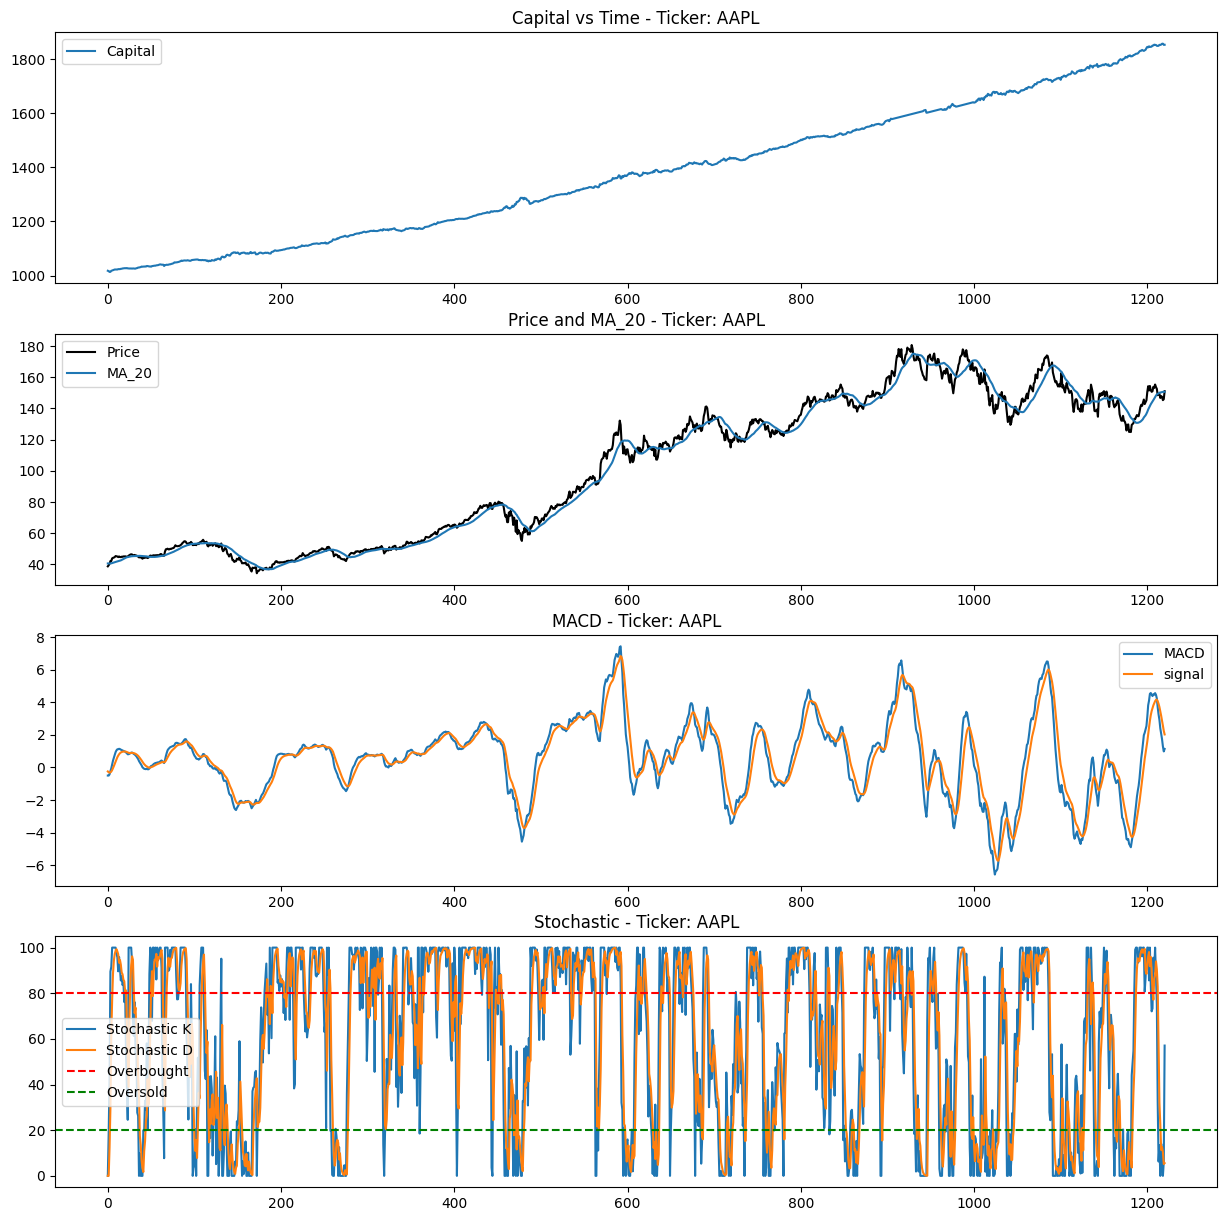



---- ITUB4.SA ----

Gross Profit: $405.02
Gross Loss: $-385.56
Gross Total: $19.46

Number of trades: 189
Hitting Ratio: 33.86%
Number of profit trades: 64
Number of loss trades: 125
Average number of events per trade: 6.21

Max win trade: $17.71
Avg win trade: $6.33
Max loss trade: $-21.23
Avg loss trade: $-3.08
Avg all trades: $0.10
Win/Loss ratio: 2.05

Max Profit: $17.71
Max Profit High/Low: $35.05
Max Drawdown: $-21.23
Max Drawdown High/Low: $-26.71

Max Allocation: $157.45
Avg Allocation: $115.28
Max Cash Required (margin): $157.45

Gross Total: $19.46
Total Fees: $37.80
Total Taxes: $82.13
Net Total: $-100.48

Gross Return: 12.72%
Average Return: 0.07%
Net Return: -91.98%
Net Return Avg Alocation: -87.16%

Number of days: 1239
Initial Capital: $1000.00
Risk Free Rate: 13.75% yearly/0.0511% daily
Total Carry: $747.23
Net Total + Carry: $646.76
Net Return Capital: 64.68%
Net Return Capital Yearly: 10.68%




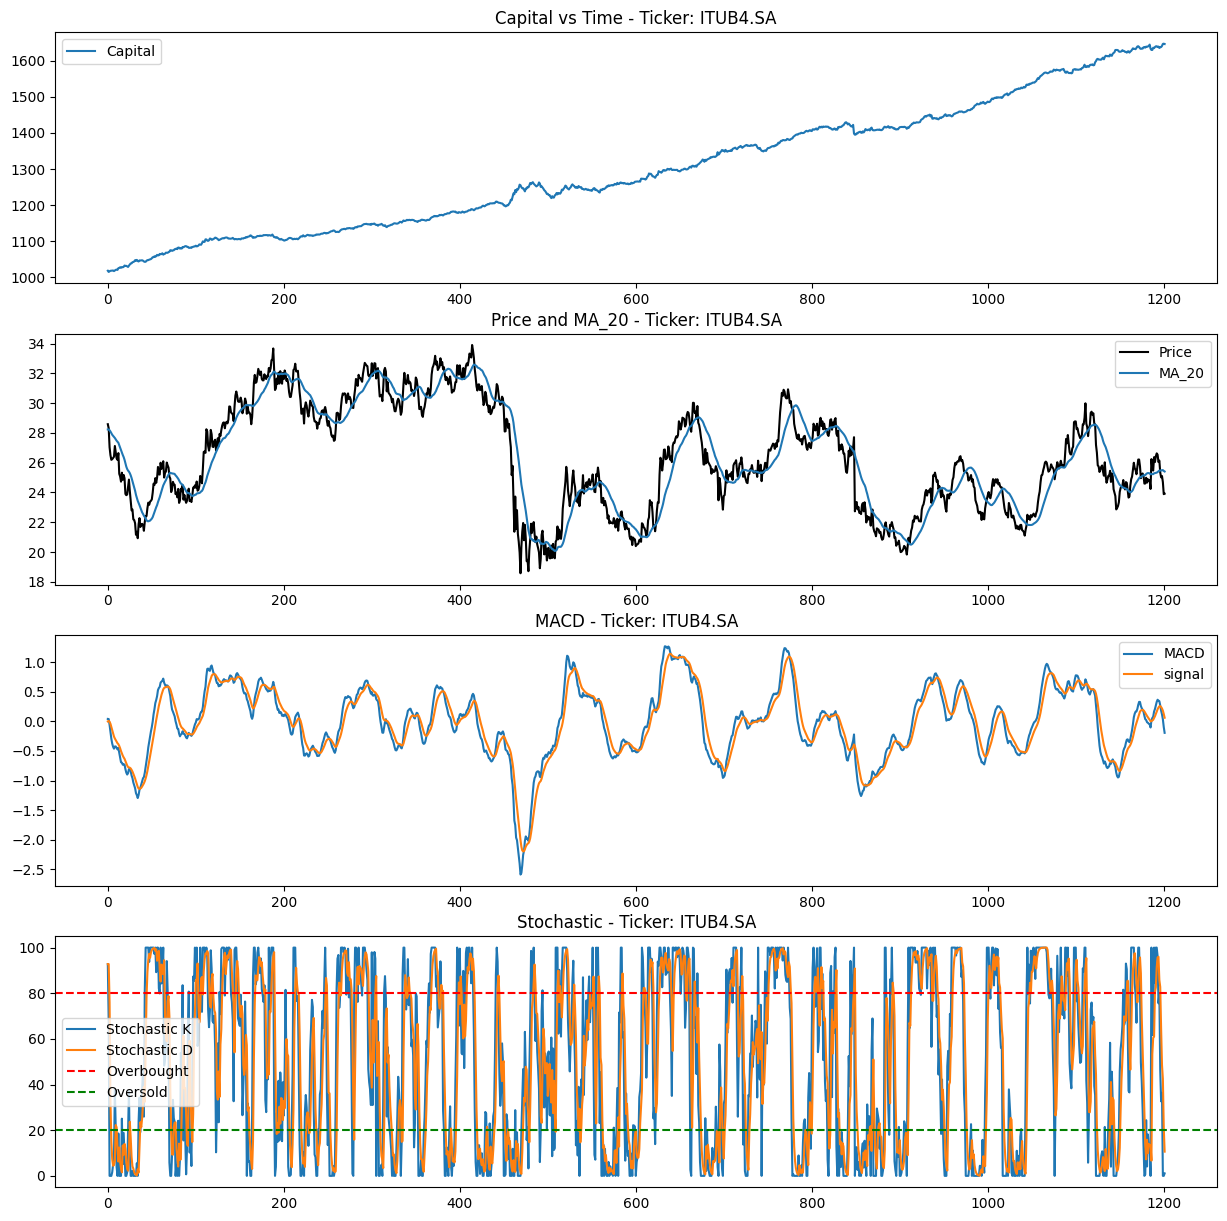



---- MRFG3.SA ----

Gross Profit: $909.06
Gross Loss: $-583.46
Gross Total: $325.61

Number of trades: 207
Hitting Ratio: 35.27%
Number of profit trades: 73
Number of loss trades: 134
Average number of events per trade: 5.47

Max win trade: $34.50
Avg win trade: $12.45
Max loss trade: $-15.92
Avg loss trade: $-4.35
Avg all trades: $1.57
Win/Loss ratio: 2.86

Max Profit: $34.50
Max Profit High/Low: $109.10
Max Drawdown: $-15.92
Max Drawdown High/Low: $-110.97

Max Allocation: $192.85
Avg Allocation: $134.95
Max Cash Required (margin): $192.85

Gross Total: $325.61
Total Fees: $41.40
Total Taxes: $163.56
Net Total: $120.65

Gross Return: 244.40%
Average Return: 1.18%
Net Return: 92.09%
Net Return Avg Alocation: 89.40%

Number of days: 1239
Initial Capital: $1000.00
Risk Free Rate: 13.75% yearly/0.0511% daily
Total Carry: $818.65
Net Total + Carry: $939.30
Net Return Capital: 93.93%
Net Return Capital Yearly: 14.42%




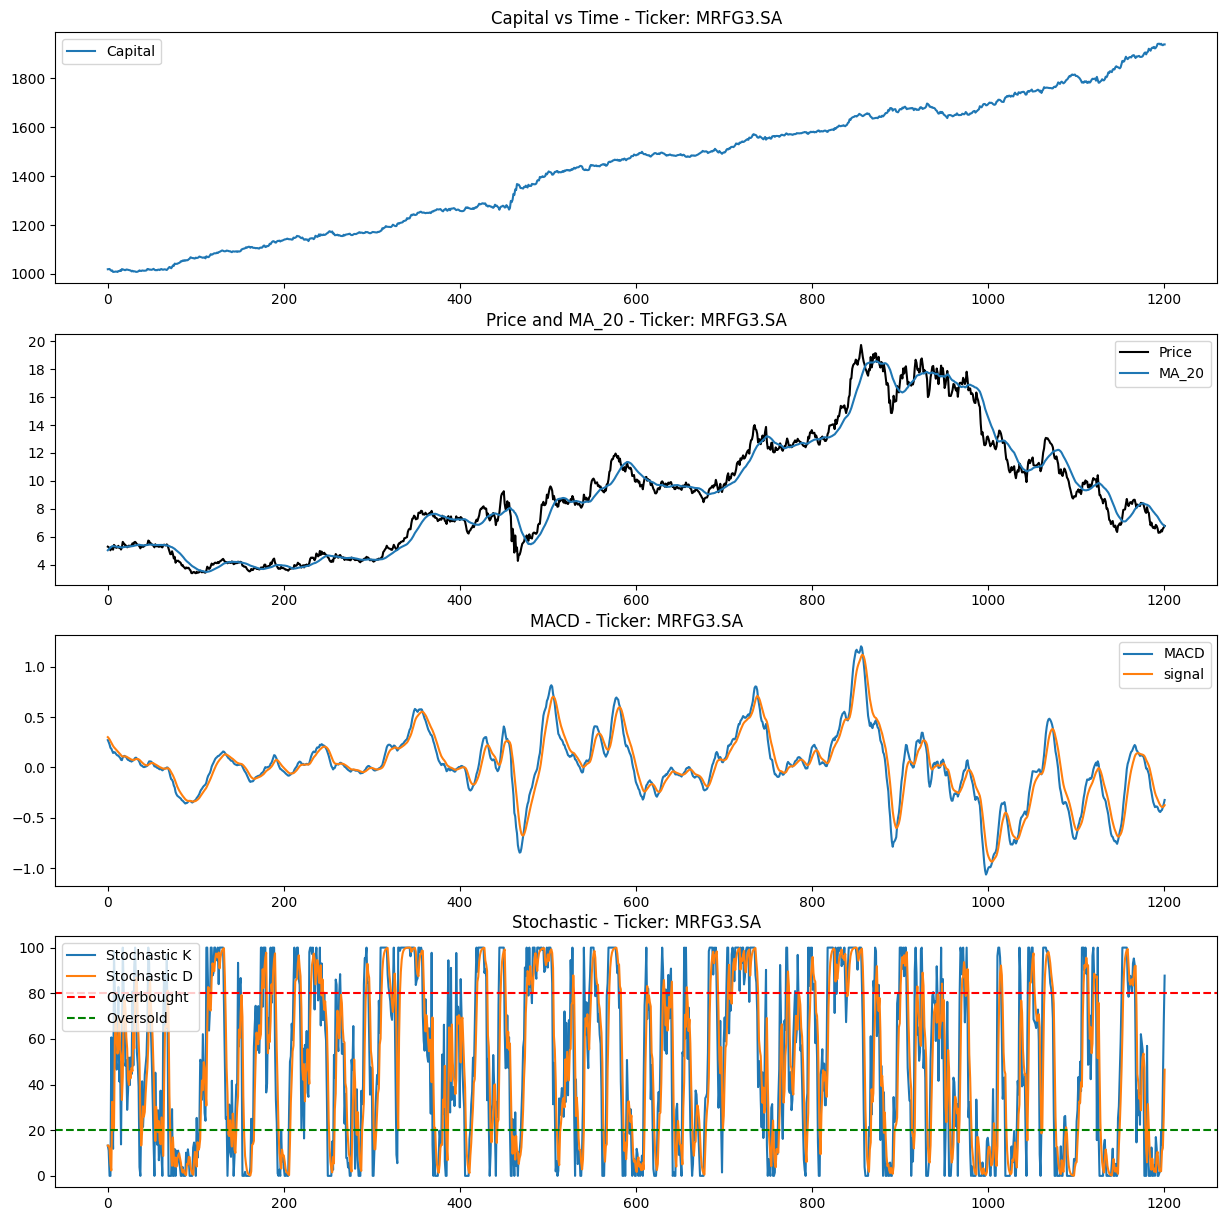

In [195]:
for ticker in tickers:
    print(f'\n\n---- {ticker} ----\n')
    modelMACDStochasticMA = MACDStochasticMA()
    print(evaluateHist(modelMACDStochasticMA, {ticker: f'{ticker}.csv'}))

    # Plot MACD, Stochastic K and D, and Moving Average indicators
    fig, ax = plt.subplots(4, 1, figsize=(15,15))

    ax[0].plot([day[0] for day in modelMACDStochasticMA._days.values()][-len(modelMACDStochasticMA.macd_indicator):])
    ax[0].legend(['Capital'])
    ax[0].set_title(f'Capital vs Time - Ticker: {ticker}')


    ax[1].plot(modelMACDStochasticMA.prices[-len(modelMACDStochasticMA.macd_indicator):], color='black')
    ax[1].plot(modelMACDStochasticMA.ma_indicator)
    ax[1].legend(['Price',f'MA_{modelMACDStochasticMA.ma_period}'])
    ax[1].set_title(f'Price and MA_{modelMACDStochasticMA.ma_period} - Ticker: {ticker}')

    ax[2].plot(modelMACDStochasticMA.macd_indicator)
    ax[2].legend(['MACD', 'signal'])
    ax[2].set_title(f'MACD - Ticker: {ticker}')

    ax[3].plot(modelMACDStochasticMA.stoch_indicator_k[-len(modelMACDStochasticMA.macd_indicator):], label='Stochastic K')
    ax[3].plot(modelMACDStochasticMA.stoch_indicator_d[-len(modelMACDStochasticMA.macd_indicator):], label='Stochastic D')
    ax[3].axhline(y=modelMACDStochasticMA.stoch_overbought, color='r', linestyle='--', label='Overbought')
    ax[3].axhline(y=modelMACDStochasticMA.stoch_oversold,   color='g', linestyle='--', label='Oversold')
    ax[3].legend()
    ax[3].set_title(f'Stochastic - Ticker: {ticker}')

    plt.show()


### Resultados

O backtest da estratégia de trading foi realizado com os últimos 5 anos de dados para cada ativo, visando cobrir uma variedade de cenários e aumentar a robustez dos resultados obtidos.

Para ITUB4.SA, foram realizadas 189 operações, sendo 64 lucrativas e 125 com prejuízo, resultando em um hitting ratio de 33.86%. O retorno médio por operação foi de \\$0.10, com um Win/Loss ratio de 2.05. A máxima perda observada foi de \\$ -21.23 e o lucro máximo foi de \\$17.71, com um lucro bruto total de \\$19.46 e um retorno líquido de -\\$100.48 após taxas e impostos.

No caso de MRFG3.SA, foram realizadas 207 operações, sendo 73 lucrativas e 134 com prejuízo, resultando em um hitting ratio de 35.27\%. O retorno médio por operação foi de \\$1.57, com um Win/Loss ratio de 2.86. A máxima perda observada foi de \\-15.92 e o lucro máximo foi de \\$34.50, com um lucro bruto total de \\$325.61 e um retorno líquido de \\$120.65 após taxas e impostos.

Já para AAPL, foram realizadas 165 operações, sendo 63 lucrativas e 101 com prejuízo, resultando em um hitting ratio de 38.18%. O retorno médio por operação foi de \\$0.94, com um Win/Loss ratio de 2.52. A máxima perda observada foi de \\$-10.32 e o lucro máximo foi de \\$ 21.07, com um lucro bruto total de \\$154.77 e um retorno líquido de \$40.08 após taxas e impostos.

### Conclusão
Com base nos resultados obtidos, a estratégia de trading apresentou desempenho heterogêneo nos diferentes ativos. Enquanto MRFG3.SA apresentou o melhor resultado, com um retorno líquido de \\$120.65 após taxas e impostos, ITUB4.SA apresentou retornos líquidos negativos. Mesmo os melhores resultados não muito expressivos.

Para melhorar essa estratégia, seria possível realizar análises mais profundas sobre as características de cada ativo, buscando identificar padrões e fatores que possam afetar seu comportamento. Além disso, seria interessante considerar outros indicadores técnicos para aprimorar as decisões de compra e venda.